# USA Water Systems and Operators

## References

## Imports and Setup

In [90]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from fuzzywuzzy import fuzz, process

In [46]:
pd.options.display.max_columns = 999

## Data

In [33]:
folder_WaterSystems = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\watersystems"
csv_FacilityFiles = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\national_combined\\NATIONAL_FACILITY_FILE.CSV"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
excel_StateFPCodes = "C:\\Users\\garfink2\\Documents\\data\\basemap\\statefpcodes.xlsx"

## Analyses

### Water Treatment Systems

In [6]:
list_StateFiles = os.listdir(folder_WaterSystems)

In [12]:
dict_StateFiles = {}
for stateFile in list_StateFiles:
    df = pd.read_csv(f"{folder_WaterSystems}/{stateFile}",encoding='cp1252')
    df["State"] = stateFile.split('.')[0].upper()
    dict_StateFiles[stateFile.split('.')[0].upper()] = df

In [31]:
df_AllStateWaterSupplies = pd.concat(list(dict_StateFiles.values()))

### National Facilities

In [22]:
nationalFacilities = pd.read_csv(csv_FacilityFiles)

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,7,11,12,13,14,15,16,21,23,24,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
nationalFacilities.head()

,FRS_FACILITY_DETAIL_REPORT_URL,REGISTRY_ID,PRIMARY_NAME,LOCATION_ADDRESS,SUPPLEMENTAL_LOCATION,CITY_NAME,COUNTY_NAME,FIPS_CODE,STATE_CODE,STATE_NAME,...,US_MEXICO_BORDER_IND,PGM_SYS_ACRNMS,LATITUDE83,LONGITUDE83,CONVEYOR,COLLECT_DESC,ACCURACY_VALUE,REF_POINT_DESC,HDATUM_DESC,SOURCE_DESC
0,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491735,OCEAN DOCK TERMINAL AND ANCHORAGE TERMINAL II,1076 OCEAN DOCK RD,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,...,NaN,"AIR:AK0000000202000032, AIRS/AFS:0202000032, B...",61.229579,-149.893094,EPA_SLT,INTERPOLATION-PHOTO,125.0,FACILITY CENTROID,NAD83,NaN
1,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491744,INLET PERTROLEUM ANCHORAGE,459 W BLUFF DR,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,...,NaN,"EIS:677611, ICIS:2600029860, ICIS:5870869, NPD...",61.231236,-149.888143,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
2,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491762,UNIVAR USA,590 E 100TH AVE,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,...,NaN,"AIR:AK0000000202000105, BR:AKD981765902, EIS:6...",61.129407,-149.871824,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
3,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491780,FAIRBANKS PETROLEUM TERMINAL,5500 AIRPORT INDUSTRIAL RD,NaN,FAIRBANKS,FAIRBANKS NORTH STAR,02090,AK,ALASKA,...,NaN,"EIS:680011, ICIS:600007563, NPDES:AKR06AB58, N...",64.811292,-147.884914,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
4,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491824,TESORO ALASKA KETCHIKAN TERMINAL,1010 STEDMAN ST,NaN,KETCHIKAN,KETCHIKAN GATEWAY,02130,AK,ALASKA,...,NaN,"EIS:540611, NPDES:AK0000523, RCRAINFO:AKD09983...",55.335010,-131.627950,FRS-TRIS,ADDRESS MATCHING-HOUSE NUMBER,30.0,CENTER OF A FACILITY OR STATION,NAD83,NaN


In [24]:
nationalFacilities.columns

Index(['FRS_FACILITY_DETAIL_REPORT_URL', 'REGISTRY_ID', 'PRIMARY_NAME',
       'LOCATION_ADDRESS', 'SUPPLEMENTAL_LOCATION', 'CITY_NAME', 'COUNTY_NAME',
       'FIPS_CODE', 'STATE_CODE', 'STATE_NAME', 'COUNTRY_NAME', 'POSTAL_CODE',
       'FEDERAL_FACILITY_CODE', 'FEDERAL_AGENCY_NAME', 'TRIBAL_LAND_CODE',
       'TRIBAL_LAND_NAME', 'CONGRESSIONAL_DIST_NUM', 'CENSUS_BLOCK_CODE',
       'HUC_CODE', 'EPA_REGION_CODE', 'SITE_TYPE_NAME', 'LOCATION_DESCRIPTION',
       'CREATE_DATE', 'UPDATE_DATE', 'US_MEXICO_BORDER_IND', 'PGM_SYS_ACRNMS',
       'LATITUDE83', 'LONGITUDE83', 'CONVEYOR', 'COLLECT_DESC',
       'ACCURACY_VALUE', 'REF_POINT_DESC', 'HDATUM_DESC', 'SOURCE_DESC'],
      dtype='object')

In [25]:
nationalFacilities["FRS_FACILITY_DETAIL_REPORT_URL"][1]

'http://ofmpub.epa.gov/enviro/fii_query_detail.disp_program_facility?p_registry_id=110000491744'

In [26]:
nationalFacilities["HUC_CODE"]

0          19020401.0
1          19020401.0
2          19020401.0
3          19040506.0
4          19010102.0
              ...    
4224068           NaN
4224069           NaN
4224070           NaN
4224071           NaN
4224072           NaN
Name: HUC_CODE, Length: 4224073, dtype: float64

### Basemap Data

In [28]:
gdf_USCounties = gpd.read_file(shp_USCounties)

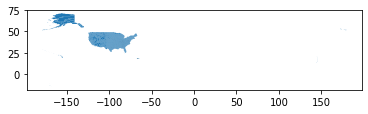

In [29]:
gdf_USCounties.plot()

In [30]:
gdf_USCounties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


### Map water systems to US counties

In [34]:
df_StateFPCodes = pd.read_excel(excel_StateFPCodes)

In [62]:
df_StateFPCodes

,Name,Postal Code,FIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6
5,Colorado,CO,8
6,Connecticut,CT,9
7,Delaware,DE,10
8,Florida,FL,12
9,Georgia,GA,13


In [38]:
df_AllStateWaterSupplies = pd.merge(left=df_AllStateWaterSupplies,right=df_StateFPCodes,left_on="State",right_on="Postal Code")

In [39]:
df_AllStateWaterSupplies

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS
0,AK2260595,ADAK UTILITIES,Community water system,Surface water,Aleutians West Census Area,ADAK,325,9,513,10,AK,Alaska,AK,2
1,AK2250037,AKHIOK,Community water system,Surface water,Kodiak Island Borough,AKHIOK,90,6,1175,8,AK,Alaska,AK,2
2,AK2272747,AKIACHAK WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIACHAK,627,6,147,4,AK,Alaska,AK,2
3,AK2272005,AKIAK COMMUNITY WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIAK,346,6,489,4,AK,Alaska,AK,2
4,AK2260252,AKUTAN,Community water system,Surface water,Aleutians East Borough,AKUTAN,95,6,572,8,AK,Alaska,AK,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143884,WY5680086,YELLOWSTONE NP-PEBBLE CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,100,10,3,9,WY,Wyoming,WY,56
143885,WY5680152,YELLOWSTONE NP-SLOUGH CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,94,10,4,7,WY,Wyoming,WY,56
143886,WY5680089,YELLOWSTONE NP-TOWER FALL CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,495,6,1,9,WY,Wyoming,WY,56
143887,WY5600471,YELLOWSTONE VALLEY INN,Transient non-community system,Ground water,Park,CODY,315,6,23,7,WY,Wyoming,WY,56


Kludge- make the decision to assign water systems to the first county in their list so that I'm not multiple-counting staffing

In [49]:
nCountiesServed = {}
list_NCountiesServed = []
list_FirstCountiesServed = []
for i,row in df_AllStateWaterSupplies.iterrows():
    counties = row["Counties Served"].split(",")
    nCounties = len(counties)
    list_NCountiesServed.append(nCounties)
    list_FirstCountiesServed.append(counties[0])
    if nCounties in nCountiesServed.keys():
        nCountiesServed[nCounties] += 1
    else:
        nCountiesServed[nCounties] = 1
df_AllStateWaterSupplies["Number of Counties Served"] = list_NCountiesServed
df_AllStateWaterSupplies["First County Served"] = list_FirstCountiesServed

In [45]:
nCountiesServed

{1: 143738, 2: 97, 3: 32, 6: 2, 4: 10, 8: 3, 5: 3, 7: 3, 10: 1}

In [50]:
df_AllStateWaterSupplies[df_AllStateWaterSupplies["Number of Counties Served"] == 10]

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS,Number of Counties Served,First County Served
113166,SD4601089,WEB WATER DEVELOPMENT ASSOCIATION,Community water system,Surface water,"Brown, Campbell, Day, Edmunds, Faulk, Marshall...","ABERDEEN, EUREKA","16,568",32,4,8,SD,South Dakota,SD,46,10,Brown


In [ ]:
df_AllStateWaterSupplies["County FIPS"] = None
for stateFP in gdf_USCounties["STATEFP"].unique():
    gdf_StateCounties = gdf_USCounties[gdf_USCounties["STATEFP"]==stateFP]
    df_WaterSuppliesSubset = df_AllStateWaterSupplies[df_AllStateWaterSupplies["FIPS"]==int(stateFP)]
    for i,row in df_WaterSuppliesSubset.iterrows():
        county = row["First County Served"]
        # find the best match of county name
        bestMatch = process.extract(county,gdf_StateCounties.NAME,limit=5)[0][0]
        countyRow = gdf_StateCounties[gdf_StateCounties["NAME"] == bestMatch].iloc[0]
        countyFIPS = countyRow["GEOID"]
        df_AllStateWaterSupplies.at[i,'County FIPS'] = countyFIPS

In [79]:
df_AllStateWaterSupplies

,PWS ID,PWS Name,PWS Type,Primary Source,Counties Served,Cities Served,PopulationServed Count,Number of Facilities,Number of Violations,Number of Site Visits,State,Name,Postal Code,FIPS,Number of Counties Served,First County Served,County FIPS
0,AK2260595,ADAK UTILITIES,Community water system,Surface water,Aleutians West Census Area,ADAK,325,9,513,10,AK,Alaska,AK,2,1,Aleutians West Census Area,"Series([], Name: GEOID, dtype: object)"
1,AK2250037,AKHIOK,Community water system,Surface water,Kodiak Island Borough,AKHIOK,90,6,1175,8,AK,Alaska,AK,2,1,Kodiak Island Borough,"Series([], Name: GEOID, dtype: object)"
2,AK2272747,AKIACHAK WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIACHAK,627,6,147,4,AK,Alaska,AK,2,1,Bethel Census Area,"Series([], Name: GEOID, dtype: object)"
3,AK2272005,AKIAK COMMUNITY WATER SYSTEM,Community water system,Ground water,Bethel Census Area,AKIAK,346,6,489,4,AK,Alaska,AK,2,1,Bethel Census Area,"Series([], Name: GEOID, dtype: object)"
4,AK2260252,AKUTAN,Community water system,Surface water,Aleutians East Borough,AKUTAN,95,6,572,8,AK,Alaska,AK,2,1,Aleutians East Borough,"Series([], Name: GEOID, dtype: object)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143884,WY5680086,YELLOWSTONE NP-PEBBLE CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,100,10,3,9,WY,Wyoming,WY,56,1,Park,"2331 56029 Name: GEOID, dtype: object"
143885,WY5680152,YELLOWSTONE NP-SLOUGH CREEK CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,94,10,4,7,WY,Wyoming,WY,56,1,Park,"2331 56029 Name: GEOID, dtype: object"
143886,WY5680089,YELLOWSTONE NP-TOWER FALL CG,Transient non-community system,Ground water,Park,YELLOWSTONE NP,495,6,1,9,WY,Wyoming,WY,56,1,Park,"2331 56029 Name: GEOID, dtype: object"
143887,WY5600471,YELLOWSTONE VALLEY INN,Transient non-community system,Ground water,Park,CODY,315,6,23,7,WY,Wyoming,WY,56,1,Park,"2331 56029 Name: GEOID, dtype: object"


In [95]:
gdf_StateCounties = gdf_USCounties[gdf_USCounties["STATEFP"]=="02"]

In [96]:
gdf_StateCounties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
75,02,130,01419973,02130,Ketchikan Gateway,Ketchikan Gateway Borough,04,H1,G4020,None,28540,None,A,12579507052,5220218255,+55.4499378,-131.1066847,"POLYGON ((-132.26804 55.63380, -132.20592 55.6..."
243,02,188,01419979,02188,Northwest Arctic,Northwest Arctic Borough,04,H1,G4020,None,None,None,A,92326483031,12878258897,+67.0050655,-160.0210864,"POLYGON ((-165.59199 68.03473, -165.57165 68.0..."
318,02,220,01419981,02220,Sitka,Sitka City and Borough,03,H6,G4020,None,None,None,C,7433222810,5037940435,+57.1932044,-135.3673965,"POLYGON ((-136.45443 57.83068, -136.44267 57.8..."
521,02,290,01419987,02290,Yukon-Koyukuk,Yukon-Koyukuk Census Area,05,H5,G4020,None,None,None,S,377030936019,5953180597,+65.3757180,-151.5778726,"POLYGON ((-149.32543 68.00000, -149.14590 68.0..."
638,02,020,01416061,02020,Anchorage,Anchorage Municipality,12,H6,G4020,None,11260,None,C,4419537010,615526050,+61.1742503,-149.2843294,"POLYGON ((-150.41994 61.16685, -150.23336 61.1..."
787,02,198,01419980,02198,Prince of Wales-Hyder,Prince of Wales-Hyder Census Area,05,H5,G4020,None,None,None,S,13630288113,14625197420,+55.6827733,-133.1623885,"MULTIPOLYGON (((-131.71335 55.09900, -131.7036..."
788,02,195,02516404,02195,Petersburg,Petersburg Borough,04,H1,G4020,None,None,None,A,7513010884,2385501229,+57.1124581,-133.0085979,"POLYGON ((-133.73413 57.23775, -133.72891 57.2..."
790,02,275,02516402,02275,Wrangell,Wrangell City and Borough,03,H6,G4020,None,None,None,C,6619614514,2384746838,+56.3174160,-132.3439780,"POLYGON ((-133.16891 56.35520, -133.16517 56.3..."
807,02,110,01419971,02110,Juneau,Juneau City and Borough,03,H6,G4020,None,27940,None,C,6829216436,1423792753,+58.6435233,-134.2811673,"POLYGON ((-135.20999 58.96771, -135.17421 58.9..."
1245,02,122,01419972,02122,Kenai Peninsula,Kenai Peninsula Borough,04,H1,G4020,None,None,None,A,41499900917,22525622024,+60.3666677,-152.3222833,"POLYGON ((-149.91984 61.04312, -149.90731 61.0..."


Going to need to implement closest match with fuzzy wuzzy

In [98]:
a = process.extract("Aleutians West Census Area",gdf_StateCounties.NAME,limit=5)

In [101]:
a[0][0]

'Aleutians West'